In [ ]:
    from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'comp451/Project/visual-transformer'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
import os
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

ROOT_PATH = PATH = '/content/drive/MyDrive/comp451/Project/visual-transformer'

os.chdir(ROOT_PATH)


Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import models
from torchsummary import summary
from models.vt_resnet20 import VTResNet20
from models.resnet import BasicBlock
import matplotlib.pyplot as plt
import random
import pickle
import PIL
import numpy as np

In [ ]:
def store_params(content, name):
    f = open("logs/" + name + ".pkl","wb")
    pickle.dump(content, f)
    f.close()

def load_params(name):
    fl = open("logs/" + name + ".pkl", "rb")
    loaded = pickle.load(fl)
    return loaded


In [ ]:
def random_seed():
    np.random.seed(8)
    torch.manual_seed(8)
    random.seed(8)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def get_data(name):

    transform_train = torchvision.transforms.Compose(
     [
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomCrop(32, 4),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    transform_valid = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    if name == 'CIFAR10':
        data_train = torchvision.datasets.CIFAR10('/data', train=True, download=True, transform=transform_train)
        data_valid = torchvision.datasets.CIFAR10('/data', train=False, download=True, transform=transform_valid)

        return data_train, data_valid
    
    if name == 'MNIST':
        data_train = torchvision.datasets.MNIST('/data', train=True, download=True, transform=transform_train)
        data_valid = torchvision.datasets.MNIST('/data', train=False, download=True, transform=transform_valid)

        return data_train, data_valid

    if name == 'ImageNet':
        data_train = torchvision.datasets.ImageNet('/content/drive/MyDrive/comp451/ /visual-transformer/data', split='train', transform=transform_train)
        data_valid = torchvision.datasets.ImageNet('/content/drive/MyDrive/comp451/Project/visual-transformer/data', split='val', transform=transform_valid)

        return data_train, data_valid

In [ ]:
data_train, data_valid = get_data('CIFAR10')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AxesImage(54,36;334.8x217.44)


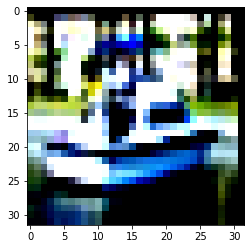

In [ ]:
print(plt.imshow(data_train[501][0].permute(1,2,0)) )

In [ ]:
def train(model, optimizer, data_loader):
   
    total_samples = len(data_loader.dataset)
    
    model.train()
    model.to(device)

    loss_history = []
    for i, (data, target) in enumerate(data_loader):
        
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + 
                  '/' + '{:5}'.format(total_samples) +
                  ' (' +
                  '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
    return loss_history

In [ ]:
def evaluate(model, data_loader, mode):
    
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0
    loss_history = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage '+ mode + ' loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')
    accuracy = 100.0 * correct_samples / total_samples
    return accuracy, loss_history

In [ ]:
def train_attempt(model, optimizer, train_data, valid_data, epochs, lr, 
                  lr_decay, decay_every, weight_decay, optim):

    all_history = []
    final_train_acc = 0
    final_valid_acc = 0
    for i in range(epochs):

        if i % decay_every == 0:
            lr *= lr_decay
            optimizer = optim(model.parameters(), lr=lr, weight_decay=weight_decay)

        history = train(model, optimizer, train_data)
        all_history = all_history + history
        plt.plot(history)
        plt.show()
        print("Epoch " + str(i) + " done.")
        final_valid_acc, valid_hist = evaluate(model, valid_data, 'test')
        final_train_acc, train_hist = evaluate(model, train_data, 'train')
        
    plt.plot(all_history)
    plt.show()

    return final_valid_acc, final_train_acc, all_history

In [ ]:
# L = 8
# D = 512
# layer_plane = [64, 128, 256, 512]
# enc_layer = 2
# n_heads = 8
# vt_channels = 128
# fc_dim = 512
# dropout = 0.5
# vt_num_layers = 1
# input_dim = 32

# # params = {
# #     'valid_acc': 91.6000, 
# #     'train_acc': 97.5620, 
# #     'lr': 0.0001, 
# #     'L': 8, 
# #     'N': 128, 
# #     'D': 512, 
# #     'optim': torch.optim.Adam, 
# #     'enc_layer': 2, 
# #     'fc_dim': 512, 
# #     'vt_channels': 128, 
# #     'dropout': 0.5, 
# #     'n_head': 8, 
# #     'vt_num_layer': 1
# # }

# params = load_params('trial9/params_11')


# model = VTResNet20(
#     vt_num_layers=params['vt_num_layer'],
#     tokens=params['L'],
#     token_channels=params['D'],
#     input_dim=input_dim,
#     vt_channels=params['vt_channels'],
#     transformer_enc_layers=params['enc_layer'],
#     transformer_heads=params['n_head'],
#     transformer_fc_dim=params['fc_dim'],
#     transformer_dropout=params['dropout'],
#     image_channels=3,
#     num_classes=10,
#     resnet_pretrained=True,
#     freeze_resnet=True
# )

# checkpoint = torch.load('saved_models/trial9/model_test_11_improved.pt')
# model.load_state_dict(checkpoint)
# model.to(device)
# print(params)

{'valid_acc': tensor(84.0200), 'train_acc': tensor(88.3960), 'lr': 0.008, 'L': 8, 'N': 128, 'D': 128, 'optim': <class 'torch.optim.adam.Adam'>, 'enc_layer': 2, 'fc_dim': 64, 'vt_channels': 64, 'dropout': 0.5, 'n_head': 1, 'vt_num_layer': 3}


In [ ]:
# test_loader = DataLoader(Subset(data_valid, list(range(5000, 10000))), batch_size=128, shuffle=False)

In [ ]:
# evaluate(model, test_loader, 'test')


Average test loss: 0.3999  Accuracy: 4368/ 5000 (87.36%)



(tensor(87.3600, device='cuda:0'), [0.3999089636325836])

In [ ]:
# lr = 0.0001
# train_loader = DataLoader(data_train, batch_size=N, shuffle=True)
# valid_loader = DataLoader(Subset(data_valid, list(range(5000))), batch_size=N, shuffle=False)
# epochs = 10
# lr_decay = 1
# decay_every = 50
# weight_decay = 4e-7
# optim = torch.optim.Adam
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# final_valid_acc, final_train_acc, all_history = train_attempt(
#     model, 
#     optimizer=optimizer, 
#     train_data=train_loader, 
#     valid_data=valid_loader, 
#     epochs=epochs, 
#     lr=lr, 
#     lr_decay=lr_decay, 
#     decay_every=decay_every,  
#     weight_decay=weight_decay,    
#     optim=optim
# )

In [ ]:
# test_loader = DataLoader(Subset(data_valid, list(range(5000, 10000))), batch_size=128, shuffle=False)
# acc, hist_loss = evaluate(model, test_loader, 'test')

In [ ]:
# torch.save(model.state_dict(), 'saved_models/trial9/model_test_12_improved_2.pt')

# The model parameters can be set manually in this cell. It supports hyper parameter search by inserting the combinations of values to be tested in arrays. The resulting models after every training attempts and their parameters are saved on disk.

In [ ]:
valid_loader = DataLoader(Subset(data_valid, list(range(5000))), batch_size=128, shuffle=False)
test_loader = DataLoader(Subset(data_valid, list(range(5000, 10000))), batch_size=128, shuffle=False)


def param_search():

    l = 0.005
    r = 0.004
    lr_trials = 1
    lrs = [0.0008]
    Ls = [4]
    Ns = [128]
    Ds = [128]
    optims = [torch.optim.Adam]
    weight_decay = 4e-5
    lr_decay = 0.1
    decay_every = 30
    epochs = 12
    enc_layers = [2]
    n_heads = [1]
    fc_dims = [64]
    t_dropout = [0.5]
    vt_channels_lst = [64]
    vt_num_layers = [3]
    input_dim = 32
    

    best_model = None
    best = {}
    best['valid_acc'] = 0

    all_count = 14
    best_count = 0
    counter = 1

    for N in Ns:
        train_loader = DataLoader(data_train, batch_size=N, shuffle=True)
        for D in Ds:
            for optim in optims:
                for vt_channels in vt_channels_lst:
                    for n_head in n_heads:
                        for fc_dim in fc_dims:
                            for dropout in t_dropout:
                                for enc_layer in enc_layers: 
                                    for L in Ls: 
                                        for lr in lrs:
                                            for vt_num_layer in vt_num_layers:
                                        
                                                
                                                model = VTResNet20(
                                                    vt_num_layers=vt_num_layer,
                                                        tokens=L,
                                                        token_channels=D,
                                                        input_dim=input_dim,
                                                        vt_channels=vt_channels,
                                                        transformer_enc_layers=enc_layer,
                                                        transformer_heads=n_head,
                                                        transformer_fc_dim=fc_dim,
                                                        transformer_dropout=dropout,
                                                        image_channels=3,
                                                        num_classes=10,
                                                        resnet_pretrained=True,
                                                        freeze_resnet=False
                                                    )
                                                model.to(device)
                                                summary(model, (3, 32, 32))
                                            
                                                optimizer = optim(model.parameters(), lr=lr, weight_decay=weight_decay)

                                                valid_acc, train_acc, all_hist = train_attempt(
                                                    model, 
                                                    optimizer, 
                                                    train_loader, 
                                                    valid_loader, 
                                                    epochs,
                                                    lr,
                                                    lr_decay,
                                                    decay_every,
                                                    weight_decay,
                                                    optim
                                                    )
                                                
                                                valid_acc = valid_acc.to('cpu')
                                                train_acc = train_acc.to('cpu')

                                                torch.save(model.state_dict(), ROOT_PATH + '/saved_models/trial9/model_test_' + str(all_count) + '.pt')
                                                counter += 1
                                                
                                                params = {
                                                    'valid_acc': valid_acc,
                                                    'train_acc': train_acc,
                                                    'lr': lr,
                                                    'L': L,
                                                    'N': N,
                                                    'D': D,
                                                    'optim': optim,
                                                    'enc_layer': enc_layer,
                                                    'fc_dim': fc_dim,
                                                    'vt_channels': vt_channels,
                                                    'dropout': dropout,
                                                    'n_head': n_head,
                                                    'vt_num_layer': vt_num_layer
                                                }

                                                if valid_acc > best['valid_acc']:
                                                    best_model = model
                                                    best = params

                                                    store_params(best, "trial9/best_params_" + str(best_count))
                                                    best_count += 1

                                                store_params(params, "trial9/params_" + str(all_count))
                                                all_count += 1

                                                print("This Epoch Params:")
                                                print(params)
                                                print("\n")

                                                print('Best So Far:')
                                                print(best)

            

    return best, best_model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
        BasicBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
       BasicBlock-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

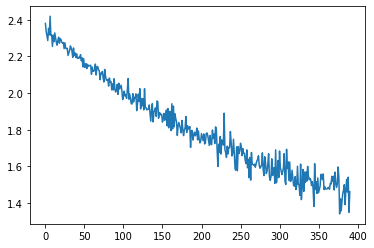

Epoch 0 done.

Average test loss: 1.4201  Accuracy: 2781/ 5000 (55.62%)


Average train loss: 1.4298  Accuracy:28483/50000 (56.97%)

[    0/50000 (  0%)]  Loss: 1.4317
[12800/50000 ( 26%)]  Loss: 1.3895
[25600/50000 ( 51%)]  Loss: 1.1953
[38400/50000 ( 77%)]  Loss: 1.2510


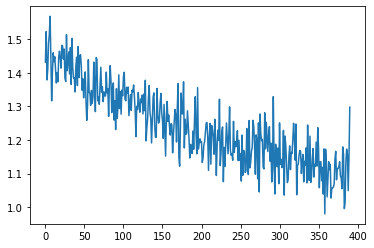

Epoch 1 done.

Average test loss: 1.0827  Accuracy: 3245/ 5000 (64.90%)


Average train loss: 1.0724  Accuracy:33267/50000 (66.53%)

[    0/50000 (  0%)]  Loss: 1.1957
[12800/50000 ( 26%)]  Loss: 0.9548
[25600/50000 ( 51%)]  Loss: 1.0244
[38400/50000 ( 77%)]  Loss: 0.8970


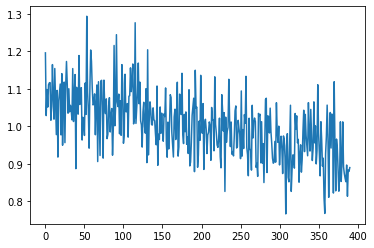

Epoch 2 done.

Average test loss: 0.9218  Accuracy: 3508/ 5000 (70.16%)


Average train loss: 0.9029  Accuracy:35647/50000 (71.29%)

[    0/50000 (  0%)]  Loss: 0.8782
[12800/50000 ( 26%)]  Loss: 0.9185
[25600/50000 ( 51%)]  Loss: 0.8086
[38400/50000 ( 77%)]  Loss: 0.8528


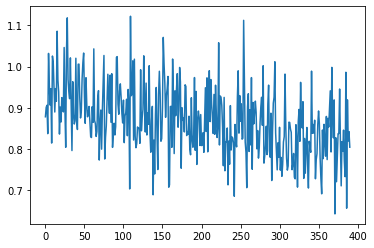

Epoch 3 done.

Average test loss: 0.8275  Accuracy: 3628/ 5000 (72.56%)


Average train loss: 0.7969  Accuracy:36948/50000 (73.90%)

[    0/50000 (  0%)]  Loss: 0.8847
[12800/50000 ( 26%)]  Loss: 0.7760
[25600/50000 ( 51%)]  Loss: 0.8630
[38400/50000 ( 77%)]  Loss: 0.7557


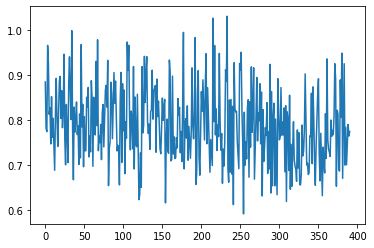

Epoch 4 done.

Average test loss: 0.7670  Accuracy: 3718/ 5000 (74.36%)


Average train loss: 0.7318  Accuracy:37815/50000 (75.63%)

[    0/50000 (  0%)]  Loss: 0.7243
[12800/50000 ( 26%)]  Loss: 0.6961
[25600/50000 ( 51%)]  Loss: 0.8986
[38400/50000 ( 77%)]  Loss: 0.7641


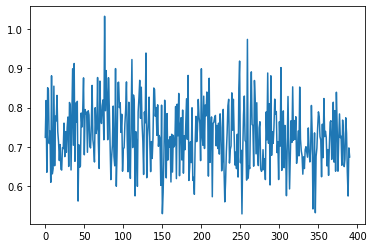

Epoch 5 done.

Average test loss: 0.7240  Accuracy: 3764/ 5000 (75.28%)


Average train loss: 0.6792  Accuracy:38649/50000 (77.30%)

[    0/50000 (  0%)]  Loss: 0.6920
[12800/50000 ( 26%)]  Loss: 0.6179
[25600/50000 ( 51%)]  Loss: 0.8176
[38400/50000 ( 77%)]  Loss: 0.5961


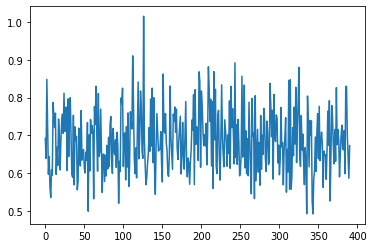

Epoch 6 done.

Average test loss: 0.6907  Accuracy: 3819/ 5000 (76.38%)


Average train loss: 0.6442  Accuracy:39217/50000 (78.43%)

[    0/50000 (  0%)]  Loss: 0.5044
[12800/50000 ( 26%)]  Loss: 0.4567
[25600/50000 ( 51%)]  Loss: 0.7114
[38400/50000 ( 77%)]  Loss: 0.7079


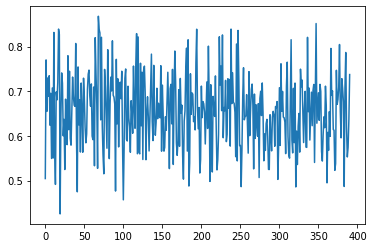

Epoch 7 done.

Average test loss: 0.6617  Accuracy: 3872/ 5000 (77.44%)


Average train loss: 0.6101  Accuracy:39790/50000 (79.58%)

[    0/50000 (  0%)]  Loss: 0.6337
[12800/50000 ( 26%)]  Loss: 0.5972
[25600/50000 ( 51%)]  Loss: 0.7444
[38400/50000 ( 77%)]  Loss: 0.7950


KeyboardInterrupt: ignored

In [ ]:
random_seed()
best, best_model = param_search()

print(best)
store_params(best, "best_of_all_test")  

acc, hist = evaluate(best_model, test_loader, 'testing')
print("Test Set Accuracy: ", acc)